In [1]:
# coding=utf-8
import math
import random
from time import time
import pandas as pd
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_iris
from sklearn import neighbors, datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import KFold
# %matplotlib

import warnings

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)


class IrisColumns(Enum):
    f1 = 'f1'
    f2 = 'f2'
    f3 = 'f3'
    f4 = 'f4'
    label = 'label'


class Foooo:
    def __init__(self, test_size=0.4):
        # self.iris = load_iris()
        columns = [c.value for c in IrisColumns]
        self.iris = pd.read_csv('./data/iris.data.csv', header=None, names=columns)
        self.model_df = None
        self.test_df = None

    def visualizations_on_features(self, val):
        g = sns.FacetGrid(self.iris, col=IrisColumns.label.value, margin_titles=True)
        g.map(sns.histplot, val)
        g.figure.subplots_adjust(top=.8)
        g.fig.suptitle("Histogram plot of feature %s of Iris dataset" % val, y=1, size=15)

    def visualization(self):
        self.visualizations_on_features(IrisColumns.f1.value)
        self.visualizations_on_features(IrisColumns.f2.value)
        self.visualizations_on_features(IrisColumns.f3.value)
        self.visualizations_on_features(IrisColumns.f4.value)

        g = sns.PairGrid(self.iris, hue=IrisColumns.label.value)
        g.map_diag(sns.histplot)
        g.map_offdiag(sns.scatterplot)
        g.add_legend()
        g.figure.subplots_adjust(top=.96)
        g.fig.suptitle("the distribution of Iris features in scatter plot and histogram plot by categories", y=0.99,
                       size=16)
        pass

    @staticmethod
    # see: https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
    def __visualize_groups_after_labels_encoding__(labels):
        # Visualize dataset groups
        fig, ax = plt.subplots()
        ax.scatter(
            range(len(labels)),
            [0.5] * len(labels),
            c=labels,
            marker="_",
            lw=50,
            cmap=plt.cm.Paired,
        )
        ax.set(
            ylim=[0, 1],
            yticks=[0.5],
            yticklabels=["Label\nGroups"],
            xlabel="Sample Size",
        )
        plt.suptitle("Label Proportions")
        plt.show()

    def labels_encoding(self):
        print("Before encoding: \n", self.iris)
        # Encode the target variable ie convert it to numeric type
        encoder = LabelEncoder()
        self.target = encoder.fit_transform(self.iris[IrisColumns.label.value].to_numpy())
        self.iris[IrisColumns.label.value] = self.target
        print("\nAfter encoding: \n", self.iris)
        self.__visualize_groups_after_labels_encoding__(self.target)

    @staticmethod
    def is_close(a, b, rel_tol=1e-09, abs_tol=0.0):
        return abs(a - b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

    @staticmethod
    # see: https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
    def __plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
        """Create a sample plot for indices of a cross-validation object."""

        # Generate the training/testing visualizations for each CV split
        for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
            # Fill in indices with the training/test groups
            indices = np.array([np.nan] * len(X))
            indices[tt] = 1
            indices[tr] = 0

            # Visualize the results
            ax.scatter(
                range(len(indices)),
                [ii + 0.5] * len(indices),
                c=indices,
                marker="_",
                lw=lw,
                cmap=plt.cm.coolwarm,
                vmin=-0.2,
                vmax=1.2,
            )

        # Plot the data classes and groups at the end
        ax.scatter(
            range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=plt.cm.Paired
        )

        ax.scatter(
            range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=plt.cm.Paired
        )

        # Formatting
        yticklabels = list(range(n_splits)) + ["iris spices", "random group"]
        ax.set(
            yticks=np.arange(n_splits + 2) + 0.5,
            yticklabels=yticklabels,
            xlabel="Sample index",
            ylabel="CV iteration",
            ylim=[n_splits + 2.2, -0.2],
            xlim=[0, group.shape[0]],
        )
        ax.set_title("{} : {}".format(type(cv).__name__, "training will sequentially access each shuffled group"),
                     fontsize=15)
        return ax

    @staticmethod
    # see : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
    def __k_fold_first_sample__():
        from sklearn.model_selection import KFold
        X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
        y = np.array([1, 2, 3, 4, 5, 6])
        kf = KFold(n_splits=3, shuffle=True)
        # get_n_splits
        kf.get_n_splits(X)  # 给出K折的折数，输出为2
        for train_index, test_index in kf.split(X):
            print("TRAIN:", train_index, "TEST:", test_index)
        # split()
        for train_index, test_index in kf.split(X):
            print("TRAIN:", train_index, "TEST:", test_index)

    def training_data_preparations(self, ptr=8, pv=1, ptt=1, g=10):
        """
        :param ptr: proportion_train
        :param pv: proportion_valid:
        :param ptt: proportion_test:
        :param g: for GroupKFold group numbers
        :return:
        """
        if ptr + pv + ptt != g:
            print("Abort: train proportion + valid proportion + test proportion != ", g)
            exit(0)

        # IDEA
        # In order to avoid rare situations like:
        #   If all the 10% test sample comes from the same label,
        #   for example label 1, then the training set will be
        #   lack of knowledge of label 1. Training will fail on
        #   testing with these label 1 samples.
        # So I code these lines in order to rewrite the function
        #   "train_test_split" to split samples
        # see： https://scikit-learn.org/stable/modules/cross_validation.html
        col_t = IrisColumns.label.value
        col_g = 'groups'
        #
        self.test_df = self.iris.groupby(col_t).sample(frac=ptt / g, random_state=123)  # random select test samples
        self.model_df = self.iris.drop(self.test_df.index.values, axis=0)  # remove test samples
        self.model_df = self.model_df.sample(frac=1, random_state=123)  # repeatable shuffle
        self.model_df = self.model_df.sort_values(by=col_t, ascending=True)  # sort by target encoded labels
        self.model_df = self.model_df.reset_index(drop=True)  # reset index for labeling KFold Groups
        # set k
        k = math.ceil((ptr + pv) / pv)
        self.model_df[col_g] = self.model_df.apply(lambda x: x.name % k, axis=1)  # labeling KFold Groups
        self.model_df = self.model_df.sort_values(by=[col_g, col_t], ascending=True)  # reorder for KFold
        X = self.model_df.drop([col_t, col_g], axis=1).to_numpy()
        y = self.model_df[col_t].to_numpy()
        groups = self.model_df[col_g].to_numpy()
        # visualization
        fig, ax = plt.subplots()
        cv = KFold(k)
        self.__plot_cv_indices(cv, X, y, groups, ax, k)  # training will sequentially access each shuffled group
        plt.show()
        return X, y, cv

    def __get_best_model(self, X, y, cv, mod, params, display_param_selection=False):
        grid_search_cv = GridSearchCV(mod, params, cv=cv)
        grid_search_cv.fit(X, y)
        if display_param_selection:
            self.print_results(grid_search_cv)
        return grid_search_cv.best_estimator_

    def __model_selection(self, func, X, y, cv):
        name, model = func(X, y, cv)
        y_pred, cost = self.predict(model)
        dic = self.metrics(y_pred)
        return name, model, dic, y_pred, cost

    def model_selection(self, ptr=8, pv=1, ptt=1, g=10,
                        open_lr=True, open_gb=True, open_rm=True, open_mlp=True, open_svm=True, ):
        X, y, cv = self.training_data_preparations(ptr, pv, ptt, g)
        if open_lr:
            name, model, dic, y_pred, cost = self.__model_selection(self.get_best_lr, X, y, cv)
            print(name, ": ", dic, "cost:", cost)
        if open_gb:
            name, model, dic, y_pred, cost = self.__model_selection(self.get_best_gb, X, y, cv)
            print(name, ": ", dic, "cost:", cost)
        if open_rm:
            name, model, dic, y_pred, cost = self.__model_selection(self.get_best_rm, X, y, cv)
            print(name, ": ", dic, "cost:", cost)
        if open_mlp:
            name, model, dic, y_pred, cost = self.__model_selection(self.get_best_mlp, X, y, cv)
            print(name, ": ", dic, "cost:", cost)
        if open_svm:
            name, model, dic, y_pred, cost = self.__model_selection(self.get_best_svm, X, y, cv)
            print(name, ": ", dic, "cost:", cost)

        pass

    @staticmethod
    def print_results(results):
        print('BEST PARAMS: {}\n'.format(results.best_params_))

        means = results.cv_results_['mean_test_score']
        stds = results.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, results.cv_results_['params']):
            print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

    def predict(self, model):
        X_test = self.test_df.drop([IrisColumns.label.value], axis=1).to_numpy()
        start = time()
        y_pred = model.predict(X_test)
        cost = (time() - start) * 1000
        return y_pred, str(round(cost, 1)) + "ms"

    def metrics(self, y_pred):
        y_test = self.test_df[IrisColumns.label.value].to_numpy()
        return {'accuracy': round(accuracy_score(y_test, y_pred), 3),
                'precision': round(precision_score(y_test, y_pred, average='macro'), 3),
                'recall': round(recall_score(y_test, y_pred, average='macro'), 3)}

    def get_best_lr(self, x, y, cv, display_param_selection=False):
        m = self.__get_best_model(x, y, cv, LogisticRegression(),
                                  {
                                      'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1.0e4]
                                  },
                                  display_param_selection)
        return 'LR', m

    def get_best_rm(self, x, y, cv, display_param_selection=False):
        m = self.__get_best_model(x, y, cv, RandomForestClassifier(),
                                  {
                                      'n_estimators': [5, 50, 250],
                                      'max_depth': [2, 4, 8, 16, 32, None]
                                  },
                                  display_param_selection)
        return 'RM', m

    def get_best_svm(self, x, y, cv, display_param_selection=False):
        m = self.__get_best_model(x, y, cv, SVC(),
                                  {
                                      'kernel': ['linear', 'rbf'],
                                      'C': [0.1, 1, 10]
                                  },
                                  display_param_selection)
        return 'SVM', m

    def get_best_mlp(self, x, y, cv, display_param_selection=False):
        m = self.__get_best_model(x, y, cv, MLPClassifier(),
                                  {
                                      'hidden_layer_sizes': [(10,), (50,), (100,)],
                                      'activation': ['relu', 'tanh', 'logistic'],
                                      'learning_rate': ['constant', 'invscaling', 'adaptive']
                                  },
                                  display_param_selection)
        return 'Multi-layer Perceptron', m

    def get_best_gb(self, x, y, cv, display_param_selection=False):
        m = self.__get_best_model(x, y, cv, GradientBoostingClassifier(),
                                  {
                                      'n_estimators': [30, 50, 100],
                                      'learning_rate': [0.003, 0.04, 0.5],
                                      'max_depth': [2, 4, 6]
                                  },
                                  display_param_selection)
        return 'Gradient Boosting', m


if __name__ == '__main__':
    foo = Foooo()


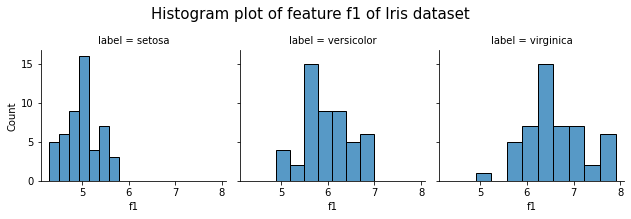

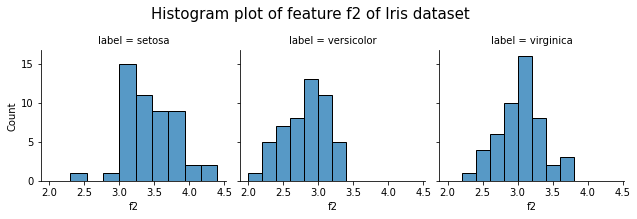

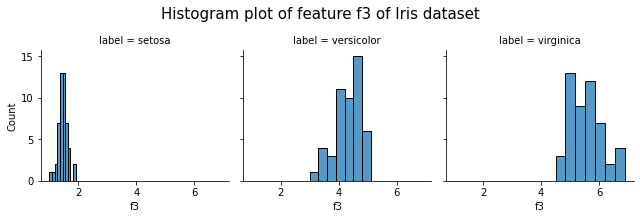

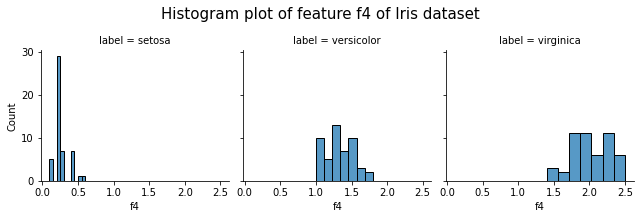

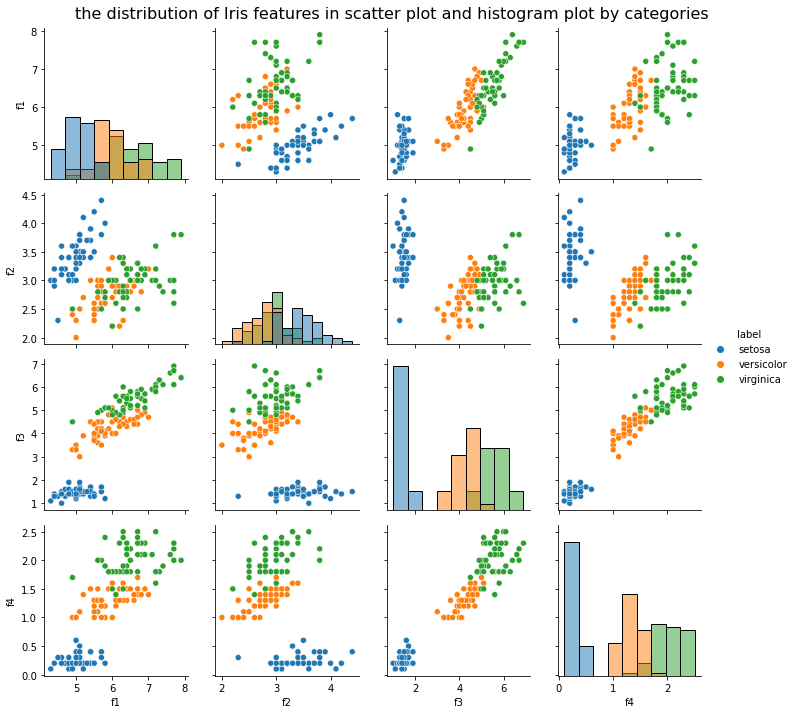

In [2]:
# Perform EDA and Explore the features using histograms
foo.visualization()

Before encoding: 
       f1   f2   f3   f4      label
0    5.1  3.5  1.4  0.2     setosa
1    4.9  3.0  1.4  0.2     setosa
2    4.7  3.2  1.3  0.2     setosa
3    4.6  3.1  1.5  0.2     setosa
4    5.0  3.6  1.4  0.2     setosa
..   ...  ...  ...  ...        ...
145  6.7  3.0  5.2  2.3  virginica
146  6.3  2.5  5.0  1.9  virginica
147  6.5  3.0  5.2  2.0  virginica
148  6.2  3.4  5.4  2.3  virginica
149  5.9  3.0  5.1  1.8  virginica

[150 rows x 5 columns]

After encoding: 
       f1   f2   f3   f4  label
0    5.1  3.5  1.4  0.2      0
1    4.9  3.0  1.4  0.2      0
2    4.7  3.2  1.3  0.2      0
3    4.6  3.1  1.5  0.2      0
4    5.0  3.6  1.4  0.2      0
..   ...  ...  ...  ...    ...
145  6.7  3.0  5.2  2.3      2
146  6.3  2.5  5.0  1.9      2
147  6.5  3.0  5.2  2.0      2
148  6.2  3.4  5.4  2.3      2
149  5.9  3.0  5.1  1.8      2

[150 rows x 5 columns]


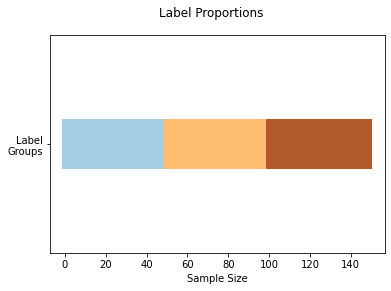

In [3]:
# label encoding
foo.labels_encoding()

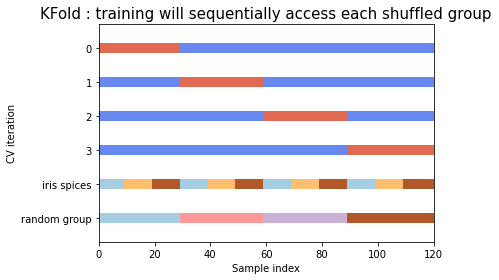

In [4]:
X, y, cv = foo.training_data_preparations(6, 2, 2, g=10)

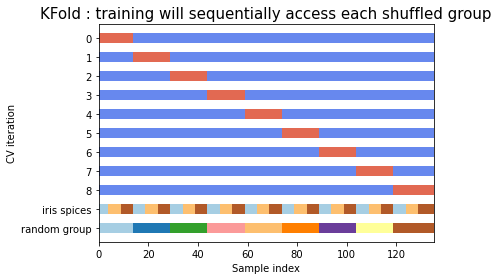

In [5]:
X, y, cv = foo.training_data_preparations(8, 1, 1, g=10)

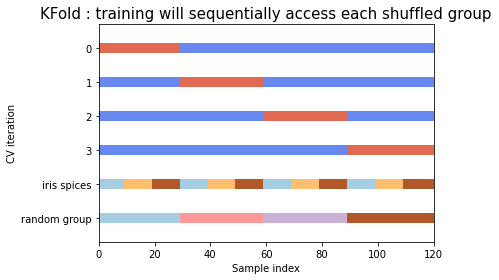

LR :  {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0} cost: 0.1ms
Gradient Boosting :  {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0} cost: 0.3ms
RM :  {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0} cost: 3.9ms
Multi-layer Perceptron :  {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0} cost: 0.3ms
SVM :  {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0} cost: 0.2ms


In [6]:
# 
foo.model_selection(6, 2, 2, g=10)

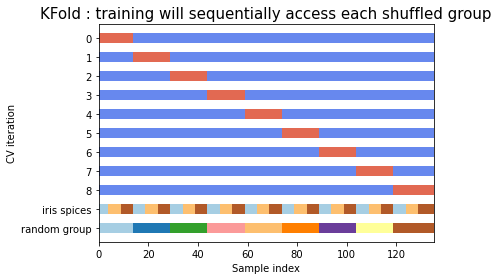

LR :  {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0} cost: 0.1ms
Gradient Boosting :  {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0} cost: 0.3ms
RM :  {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0} cost: 4.5ms
Multi-layer Perceptron :  {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0} cost: 0.2ms
SVM :  {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0} cost: 0.1ms


In [7]:
foo.model_selection(8, 1, 1, g=10)